<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

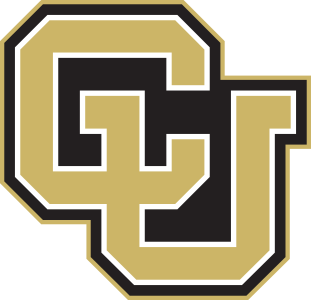

# Lecture 9, hands-on: permutations
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Lauren Vanderlinden__ and __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Data setup
- Make sure your environment has the following packages:
  - `python=3.12.*`
  - `numpy`
  - `pandas`
  - `scipy`
  - `matplotlib`
  - `seaborn`
- Download these files and place them somewhere (`/tmp/` folder used below):
  - `permutations_arraydata.txt` from [this link](https://www.dropbox.com/scl/fi/e4si92dnroq2dnzkjdx84/permutations_arraydata.txt?rlkey=7g0xu530c9avhqkf2i8vrmr1d&st=uyc6w3v1&dl=0).
  - `permutations_genenames.txt` from [this link](https://www.dropbox.com/scl/fi/ving1wxzsmydkq95gvlno/permutations_genenames.txt?rlkey=6grtzbitwlzbfgqy9uhgezcku&st=vpn4859h&dl=0).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations

# Set random seed for reproducibility
np.random.seed(7602)

# Set plot style
sns.set_style("whitegrid")

## Example 1: GRE Scores Between 20 Years

GRE score data was collected over 2 different years (2000 and 2020) to test our main research question: have GRE scores changed significantly over 20 years?

In [3]:
# Create mock example data on GRE scores
year1 = np.array([500, 450, 600, 700, 550, 551, 552])
year2 = np.array([560, 460, 620, 720, 540, 600, 750])

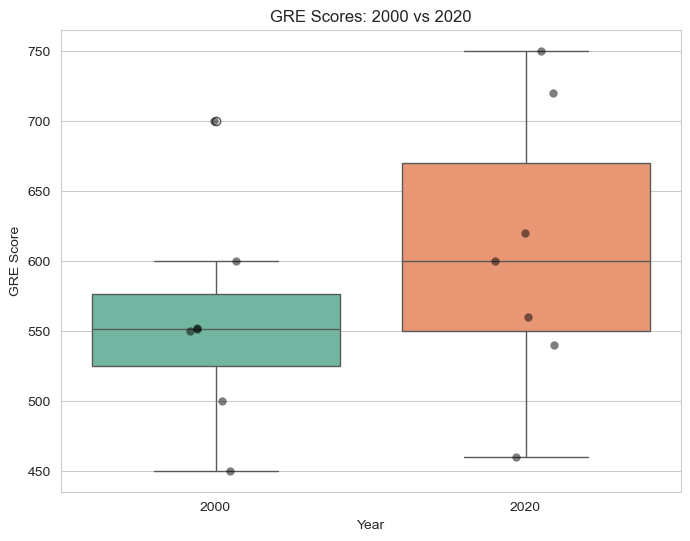

In [4]:
# Create dataframe for plotting
df_gre = pd.DataFrame({
    'score': np.concatenate([year1, year2]),
    'year': ['2000'] * len(year1) + ['2020'] * len(year2)
})

# Plot the data
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_gre, x='year', y='score', hue="year", palette='Set2', legend=False)
sns.stripplot(data=df_gre, x='year', y='score', color='black', alpha=0.5, size=6)
plt.title('GRE Scores: 2000 vs 2020')
plt.ylabel('GRE Score')
plt.xlabel('Year')
plt.show()

In [5]:
# Run the t-test
t_stat, p_value = stats.ttest_ind(year1, year2)
print(f"T-test results:")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.4f}")

T-test results:
  T-statistic: -1.0218
  P-value: 0.3270


In [5]:
# Calculate degrees of freedom
df = len(year1) + len(year2) - 2
print(f"  Degrees of freedom: {df}")

  Degrees of freedom: 12


In [6]:
# Two-tailed p-value using t-distribution
p_value_manual = 2 * stats.t.cdf(-abs(t_stat), df)
print(f"  P-value (manual calculation): {p_value_manual:.4f}")

  P-value (manual calculation): 0.3270


### Permutation test for GRE scores

In [6]:
# Permutation test
pool_data = np.concatenate([year1, year2])
m = len(year1)
n = len(year2)
total_n = m + n

# Number of permutations
B = 1000

# Generate permutations
perm_t = np.zeros(B)

for i in range(B):
    if (i + 1) % 20 == 0:
        print(f"Iteration: {i + 1}")

    # Randomly sample m indices for group 1
    group1_idx = np.random.choice(total_n, m, replace=False)
    group2_idx = np.setdiff1d(np.arange(total_n), group1_idx)

    # Calculate t-statistic for this permutation
    perm_t[i], _ = stats.ttest_ind(pool_data[group1_idx], pool_data[group2_idx])

Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180
Iteration: 200
Iteration: 220
Iteration: 240
Iteration: 260
Iteration: 280
Iteration: 300
Iteration: 320
Iteration: 340
Iteration: 360
Iteration: 380
Iteration: 400
Iteration: 420
Iteration: 440
Iteration: 460
Iteration: 480
Iteration: 500
Iteration: 520
Iteration: 540
Iteration: 560
Iteration: 580
Iteration: 600
Iteration: 620
Iteration: 640
Iteration: 660
Iteration: 680
Iteration: 700
Iteration: 720
Iteration: 740
Iteration: 760
Iteration: 780
Iteration: 800
Iteration: 820
Iteration: 840
Iteration: 860
Iteration: 880
Iteration: 900
Iteration: 920
Iteration: 940
Iteration: 960
Iteration: 980
Iteration: 1000


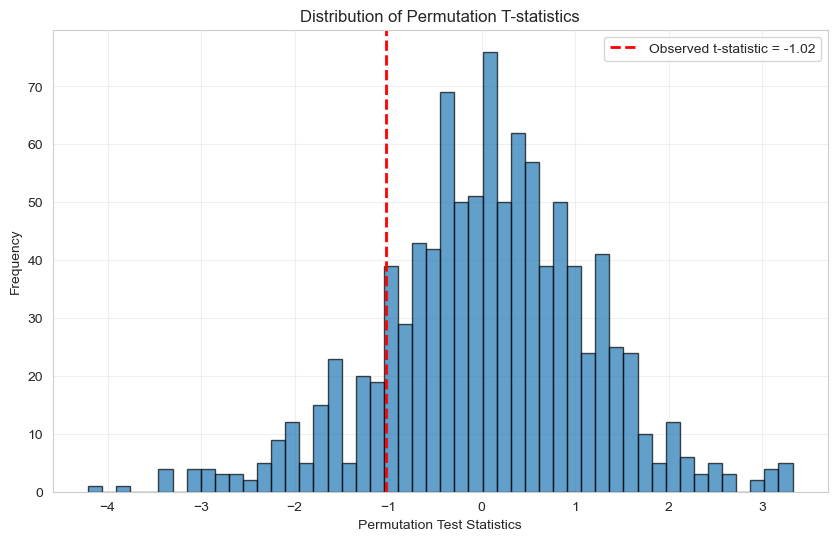


Permutation test results:
  Number of extreme values: 323
  Permutation p-value: 0.3230
  Parametric p-value: 0.3270


In [7]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(perm_t, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(t_stat, color='red', linestyle='--', linewidth=2,
            label=f'Observed t-statistic = {t_stat:.2f}')
plt.xlabel('Permutation Test Statistics')
plt.ylabel('Frequency')
plt.title('Distribution of Permutation T-statistics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate permutation p-value
n_extreme = np.sum(np.abs(perm_t) > np.abs(t_stat))
perm_p_value = n_extreme / B

print(f"\nPermutation test results:")
print(f"  Number of extreme values: {n_extreme}")
print(f"  Permutation p-value: {perm_p_value:.4f}")
print(f"  Parametric p-value: {p_value:.4f}")

## Example 2: Apolipoprotein AI and Liver Expression in Mice

We are interested in testing whether there are genes that are differentially expressed between the control and knock-out group for each gene. Obtain the p-values from a two-sided t-test for differential expression using permutations (B=12870 possibilities), where the labels of the two mouse groups are shuffled. How many genes are significant at the 0.01 level? Print out a table with the top 10 genes, their t-statistics, permutation p-value and fold change. Data is already normalized and log transformed.

In [8]:
# Set working directory where data files are located
wd = "/Users/emilyekstrum/Downloads/"

# Read in data
ApoAI = pd.read_csv(f"{wd}permutations_arraydata.txt", sep="\t")
# rows: genes, columns: samples (1-8: control, 9-16: knockout)

In [9]:
ApoAI.shape

(6384, 16)

In [10]:
ApoAI.head()

,c1,c2,c3,c4,c5,c6,c7,c8,k1,k2,k3,k4,k5,k6,k7,k8
1,7.669900,6.721563,7.077078,5.818323,8.257974,6.753425,7.395970,6.391309,8.106206,7.397413,9.318577,7.106212,8.068457,7.772820,8.431817,7.555878
2,8.100814,8.175672,8.316254,8.084957,9.134773,8.055908,9.067418,7.816866,9.494243,8.974139,10.002668,8.073490,9.711959,9.582453,9.915386,8.860248
3,7.653958,6.931564,6.910529,6.534889,10.077608,7.560903,7.525893,7.783491,7.814372,7.360648,7.514425,8.406679,6.721119,9.344291,8.818216,9.009613
4,7.741055,7.907203,7.574789,7.833888,8.752796,7.883263,7.846471,7.840175,8.408022,8.304256,7.847225,7.643289,7.488055,8.306266,7.817330,8.051084
5,6.741500,7.855348,7.866832,7.583525,7.394431,8.015773,7.610074,7.931695,7.901746,8.421122,7.665509,7.662932,8.137817,7.909780,8.562980,7.413547


In [11]:
n_genes = ApoAI.shape[0]
n_samples = ApoAI.shape[1]

In [12]:
# Read gene names (don't skip genes without annotation)
with open(f"{wd}permutations_genenames.txt", 'r') as f:
    ApoAInames = [line.strip() for line in f]

In [13]:
ApoAInames[:10]

['Cy3RT',
 'Cy5RT',
 'mSRB1',
 'BLANK',
 'BLANK',
 'BLANK',
 '',
 "5'similartoSW:BTF3_H",
 "5'similartogb:J04794",
 "5'.gi|1287586|gb|W13"]

In [14]:
print(f"Dataset dimensions:")
print(f"  Number of genes: {n_genes}")
print(f"  Number of samples: {n_samples}")
print(f"  Control samples: 0-7")
print(f"  Knockout samples: 8-15")

Dataset dimensions:
  Number of genes: 6384
  Number of samples: 16
  Control samples: 0-7
  Knockout samples: 8-15


### Calculate observed t-statistics

In [15]:
# Calculate observed t-statistics for all genes
t_statistic = np.zeros(n_genes)

# We'll also compute the analytical p-value to compare with the permuted-one
t_statistic_pval = np.zeros(n_genes)

for i in range(n_genes):
    control = ApoAI.iloc[i, 0:8].values
    knockout = ApoAI.iloc[i, 8:16].values
    t_statistic[i], t_statistic_pval[i] = stats.ttest_ind(control, knockout)

# Check first gene as example
i = 0
control_sample = ApoAI.iloc[i, 0:8].values
knockout_sample = ApoAI.iloc[i, 8:16].values
t_test_result = stats.ttest_ind(control_sample, knockout_sample)

print(f"Example - First gene:")
print(f"  Gene name: {ApoAInames[i]}")
print(f"  T-statistic: {t_test_result.statistic:.4f}")
print(f"  P-value: {t_test_result.pvalue:.4f}")
print(f"  Mean control: {np.mean(control_sample):.4f}")
print(f"  Mean knockout: {np.mean(knockout_sample):.4f}")

Example - First gene:
  Gene name: Cy3RT
  T-statistic: -2.6305
  P-value: 0.0198
  Mean control: 7.0107
  Mean knockout: 7.9697


### Permutation test for differential expression

We'll perform permutation tests for all genes. For computational efficiency, we'll use a subset of all possible permutations.

In [16]:
# Number of ways to select 8 samples out of 16
from math import comb
n_possible_perms = comb(16, 8)
print(f"Total possible permutations: {n_possible_perms:,}")

# For this example, we'll use B=100 permutations for speed
# In practice, you might want to use all 12,870 permutations or a larger B
B = 100

# Create matrix to store permutation t-statistics
tstat_mat = np.zeros((n_genes, B))

# Generate combinations (or use random permutations)
labels = np.arange(16)

print(f"\nRunning {B} permutations...")
for i in range(B):
    if (i + 1) % 20 == 0:
        print(f"  Permutation: {i + 1}")

    # Randomly select 8 samples for group 1
    group1_idx = np.random.choice(16, 8, replace=False)
    group2_idx = np.setdiff1d(labels, group1_idx)

    # Calculate t-statistic for each gene with this permutation
    for g in range(n_genes):
        gene_data = ApoAI.iloc[g, :].values
        tstat_mat[g, i], _ = stats.ttest_ind(
            gene_data[group1_idx],
            gene_data[group2_idx]
        )

print("Permutation testing complete!")

Total possible permutations: 12,870

Running 100 permutations...
  Permutation: 20
  Permutation: 40
  Permutation: 60
  Permutation: 80
  Permutation: 100
Permutation testing complete!


### Analyze first gene's permutation distribution

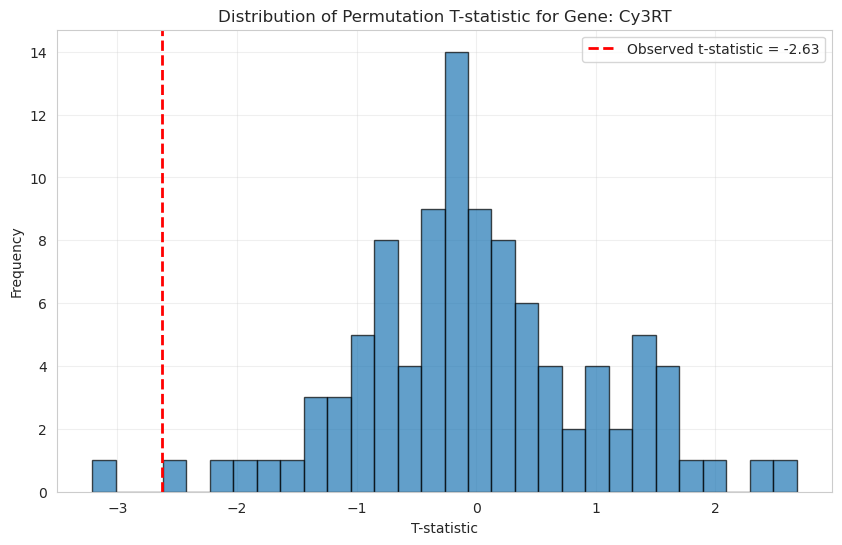

Gene: Cy3RT
  Number of extreme values: 2
  Permutation p-value: 0.0200


In [18]:
# Check first gene
i = 0

plt.figure(figsize=(10, 6))
plt.hist(tstat_mat[i, :], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(t_statistic[i], color='red', linestyle='--', linewidth=2,
           label=f'Observed t-statistic = {t_statistic[i]:.2f}')
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title(f'Distribution of Permutation T-statistic for Gene: {ApoAInames[i]}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate p-value for first gene
n_extreme = np.sum(np.abs(tstat_mat[i, :]) >= np.abs(t_statistic[i]))
perm_p_first = n_extreme / B
print(f"Gene: {ApoAInames[i]}")
print(f"  Number of extreme values: {n_extreme}")
print(f"  Permutation p-value: {perm_p_first:.4f}")

### Calculate permutation p-values for all genes

In [19]:
# Calculate permutation p-values for all genes
p_value_perm = np.zeros(n_genes)

for i in range(n_genes):
    p_value_perm[i] = np.sum(np.abs(tstat_mat[i, :]) >= np.abs(t_statistic[i])) / B

# Count significant genes at 0.01 level
n_significant = np.sum(p_value_perm <= 0.01)
print(f"Number of genes significant at 0.01 level: {n_significant}")

# Get gene names for significant genes
significant_genes = [ApoAInames[i] for i in range(n_genes) if p_value_perm[i] <= 0.01]
print(f"\nSignificant genes:")
for gene in significant_genes[:20]:  # Show first 20
    print(f"  {gene}")
if len(significant_genes) > 20:
    print(f"  ... and {len(significant_genes) - 20} more")

Number of genes significant at 0.01 level: 251

Significant genes:
  Cy5RT
  
  5'similartoSW:ATP6_M
  unk
  delta-opioidreceptor
  BLANK
  est
  est
  ESTs,Moderatelysimil
  BLANK
  EST,HighlysimilartoA
  GAMMA-AMINOBUTYRIC-A
  MousemRNAforfarnesyl
  FATTYACID-BINDINGPRO
  MDB0131
  MDB0145
  MDB0147
  MDB0712
  MDB0743
  MDB1376
  ... and 231 more


### Create summary table of top 10 genes

In [20]:
# Calculate fold change (difference in means for log-transformed data)
fold_change = np.zeros(n_genes)
mean_control = np.zeros(n_genes)
mean_knockout = np.zeros(n_genes)

for i in range(n_genes):
    mean_control[i] = np.mean(ApoAI.iloc[i, 0:8].values)
    mean_knockout[i] = np.mean(ApoAI.iloc[i, 8:16].values)
    fold_change[i] = mean_knockout[i] - mean_control[i]  # log fold change

# Create results dataframe
results_df = pd.DataFrame({
    'Gene': ApoAInames,
    'T-statistic': t_statistic,
    'Perm_P-value': p_value_perm,
    'Log_Fold_Change': fold_change,
    'Mean_Control': mean_control,
    'Mean_Knockout': mean_knockout
})

# Sort by p-value and get top 10
top_10_genes = results_df.sort_values(['Log_Fold_Change', 'Perm_P-value'], ascending=[True, True]).head(10)

print("\nTop 10 genes by permutation p-value:")
print(top_10_genes.to_string(index=False))


Top 10 genes by permutation p-value:
                Gene  T-statistic  Perm_P-value  Log_Fold_Change  Mean_Control  Mean_Knockout
     ApoAI,lipid-Img    23.104347          0.00        -4.749247      8.147709       3.398463
EST,HighlysimilartoA    11.762486          0.00        -4.572826      8.245822       3.672996
CATECHOLO-METHYLTRAN    11.759068          0.00        -2.772249      8.003259       5.231010
EST,WeaklysimilartoC    12.982368          0.00        -1.540431      7.588145       6.047714
ESTs,Highlysimilarto     9.018613          0.00        -1.514718      7.835267       6.320549
                 est     9.087422          0.00        -1.466135      7.704867       6.238731
similartoyeaststerol     7.208906          0.00        -1.432454      7.356597       5.924143
   ApoCIII,lipid-Img    10.430072          0.00        -1.398874      7.781127       6.382253
psoriasis-associated     3.550547          0.01        -1.256713      7.742241       6.485528
EST,Moderatelysimila  

### Visualize results

#### Using permuted-data based p-values

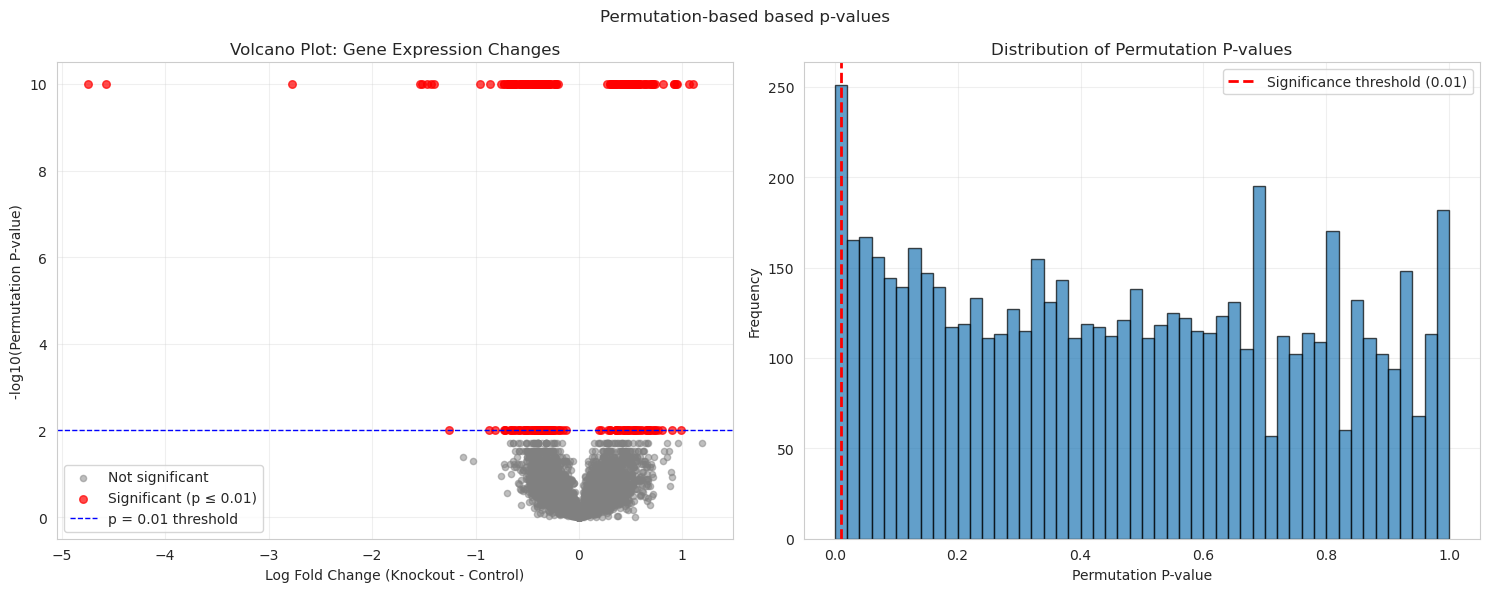

In [25]:
# Create volcano plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Permutation-based based p-values")

# Volcano plot
log_p = -np.log10(p_value_perm + 1e-10)  # Add small value to avoid log(0)
significant_mask = p_value_perm <= 0.01

ax1.scatter(fold_change[~significant_mask], log_p[~significant_mask],
           c='gray', alpha=0.5, s=20, label='Not significant')
ax1.scatter(fold_change[significant_mask], log_p[significant_mask],
           c='red', alpha=0.7, s=30, label='Significant (p ≤ 0.01)')
ax1.axhline(-np.log10(0.01), color='blue', linestyle='--', linewidth=1,
           label='p = 0.01 threshold')
ax1.set_xlabel('Log Fold Change (Knockout - Control)')
ax1.set_ylabel('-log10(Permutation P-value)')
ax1.set_title('Volcano Plot: Gene Expression Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# P-value distribution
ax2.hist(p_value_perm, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0.01, color='red', linestyle='--', linewidth=2,
           label='Significance threshold (0.01)')
ax2.set_xlabel('Permutation P-value')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Permutation P-values')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Using ttest_ind based p-values

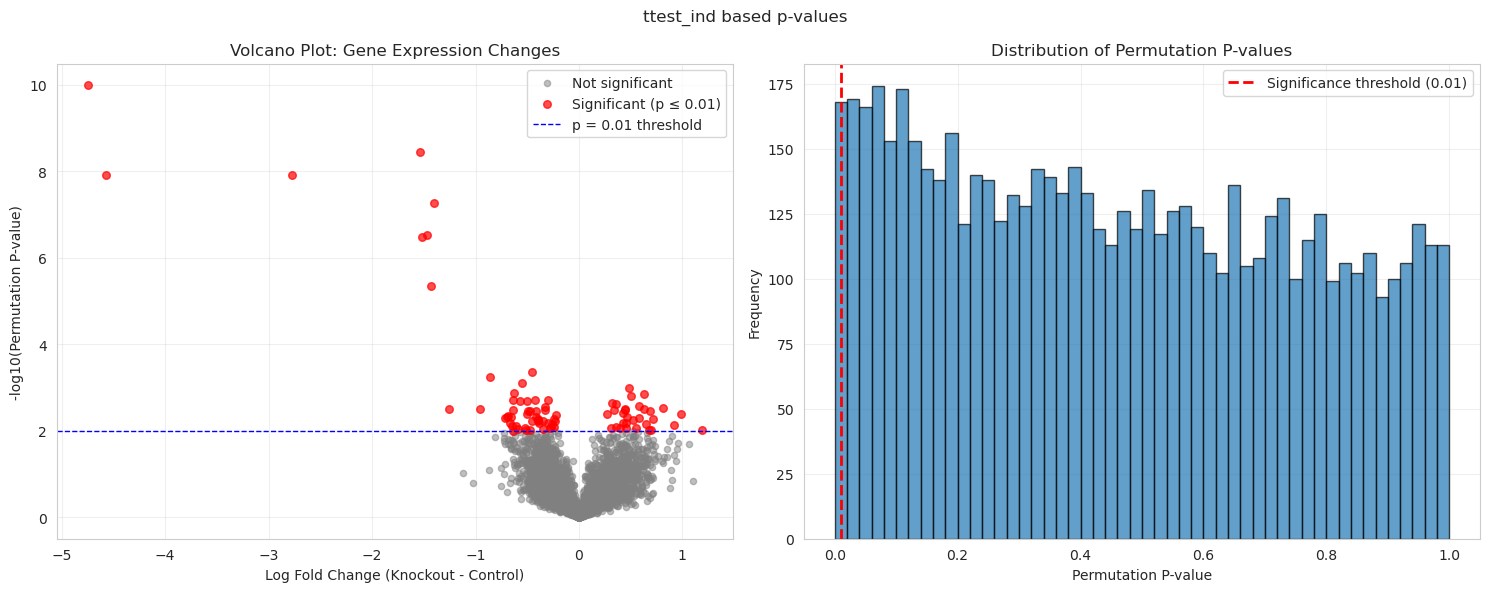

In [24]:
# Create volcano plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("ttest_ind based p-values")

# Volcano plot
log_p = -np.log10(t_statistic_pval + 1e-10)  # Add small value to avoid log(0)
significant_mask = t_statistic_pval <= 0.01

ax1.scatter(fold_change[~significant_mask], log_p[~significant_mask],
           c='gray', alpha=0.5, s=20, label='Not significant')
ax1.scatter(fold_change[significant_mask], log_p[significant_mask],
           c='red', alpha=0.7, s=30, label='Significant (p ≤ 0.01)')
ax1.axhline(-np.log10(0.01), color='blue', linestyle='--', linewidth=1,
           label='p = 0.01 threshold')
ax1.set_xlabel('Log Fold Change (Knockout - Control)')
ax1.set_ylabel('-log10(Permutation P-value)')
ax1.set_title('Volcano Plot: Gene Expression Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# P-value distribution
ax2.hist(t_statistic_pval, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0.01, color='red', linestyle='--', linewidth=2,
           label='Significance threshold (0.01)')
ax2.set_xlabel('Permutation P-value')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Permutation P-values')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Alternative: Using all possible permutations (computationally intensive)

**Note**: The code below is commented out as it's computationally intensive. With 12,870 permutations and thousands of genes, this can take significant time. Use only if needed.

In [23]:
# OPTIONAL: Run with all possible permutations (commented out for speed)
# Warning: This will take considerable time!

# from itertools import combinations
#
# # Generate all possible combinations
# perms = list(combinations(range(16), 8))
# n_perms = len(perms)
# print(f"Total permutations: {n_perms}")
#
# # Initialize array to count extreme values
# sum_extreme = np.zeros(n_genes)
#
# for i in range(n_perms):
#     if (i + 1) % 1000 == 0:
#         print(f"Permutation: {i + 1}/{n_perms}")
#
#     group1_idx = np.array(perms[i])
#     group2_idx = np.setdiff1d(np.arange(16), group1_idx)
#
#     # Calculate t-statistics for all genes
#     for g in range(n_genes):
#         gene_data = ApoAI.iloc[g, :].values
#         perm_tstat, _ = stats.ttest_ind(
#             gene_data[group1_idx],
#             gene_data[group2_idx]
#         )
#
#         # Count if this permutation's t-stat is more extreme
#         if np.abs(t_statistic[g]) <= np.abs(perm_tstat):
#             sum_extreme[g] += 1
#
# # Calculate exact permutation p-values
# perm_p_exact = sum_extreme / n_perms
#
# print(f"\nNumber of genes significant at 0.01 level: {np.sum(perm_p_exact < 0.01)}")